In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt

In [52]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='03:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(20)

# Setup your client
client = Client(cluster)

In [53]:
client.cluster

### refactoring get_map

In [ ]:
f=get_files('transient',yy=(2010,2014))[0][0]
ds=xr.open_dataset(f)
sg=xr.open_dataset('clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc')
out=np.zeros(sg.cclass.shape)+np.nan
for c,(o,a) in enumerate(sg.rcent_coords):
    i=np.arange(400)[
        (abs(ds.grid1d_lat-a)<0.1)&
        (abs(ds.grid1d_lon-o)<0.1)]
    out[sg.cclass==c+1]=i
cclass=out.copy()
cclass[np.isnan(out)]=0

sgmap=xr.Dataset()
sgmap['cclass']=xr.DataArray(cclass.astype(int),dims=['lat','lon'])
sgmap['notnan']=xr.DataArray(~np.isnan(out),dims=['lat','lon'])
sgmap['lat']=sg.lat
sgmap['lon']=sg.lon
sgmap.to_netcdf('sgmap.nc')

### read in the sparsegrid info

In [7]:
thedir  = '/glade/u/home/forrest/ppe_representativeness/output_v4/'
thefile = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
sg = xr.open_dataset(thedir+thefile)

### map of the clusters

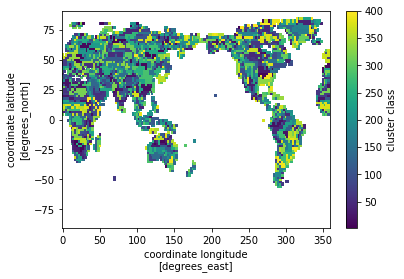

In [9]:
sg.cclass.plot();

In [4]:
### read in an example fullgrid output file

In [57]:
d='/glade/p/cgd/tss/people/oleson/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
files=sorted(glob.glob(d+'*h0*'))[-120:]

In [84]:
tmp=xr.open_dataset(files[0])
la0=tmp.area*tmp.landfrac

In [58]:
def preprocess(ds):
    dvs=['TLAI','EFLX_LH_TOT']
    return ds[dvs]

In [59]:
ds=xr.open_mfdataset(files,combine='nested',concat_dim='time',parallel=True,
                     preprocess=preprocess,decode_times=False)
ds['time']=xr.cftime_range('2005',periods=120,freq='MS')

In [63]:
f='/glade/campaign/asp/djk2120/PPEn11/CTL2010/hist/PPEn08_CTL2010_OAAT0000.clm2.h0.2005-02-01-00000.nc'
ds2=xr.open_dataset(f)
ivals=ds2.grid1d_ixy.astype(int)-1  #python indexing starts at 0
jvals=ds2.grid1d_jxy.astype(int)-1

In [66]:
lai=ds.TLAI[:,jvals,ivals]
et=ds.EFLX_LH_TOT[:,jvals,ivals]

In [85]:
la=xr.open_dataset('sparsegrid_landarea.nc').landarea
la

<xarray.DataArray 'landarea' (gridcell: 400)>
array([ 43876.945312,  74021.492188,  18694.408203, ...,  96467.828125,
       101825.101562,  42073.671875])
Dimensions without coordinates: gridcell
Attributes:
    long_name:  total area of represented gridcells
    units:      km2

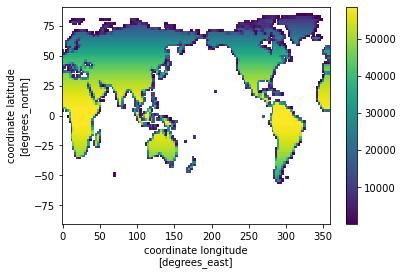

In [100]:
f = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
sg = xr.open_dataset(f)
la = sg.landfrac*sg.area
la.plot()

In [98]:
sg

<xarray.Dataset>
Dimensions:        (coords: 2, lat: 96, lon: 144, numclust: 400)
Coordinates:
  * lon            (lon) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * lat            (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
Dimensions without coordinates: coords, numclust
Data variables:
    area           (lat, lon) float32 ...
    landfrac_orig  (lat, lon) float32 ...
    landfrac       (lat, lon) float32 ...
    cclass         (lat, lon) float64 ...
    rcent          (lat, lon) float64 ...
    rcent_coords   (numclust, coords) float32 ...
Attributes:
    title:    Cluster analysis results for CLM5
    history:  Created on Sun Feb 21 03:57:24 2021
    contact:  Forrest Hoffman <forrest@climatemodeling.org>
    case_id:  clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist

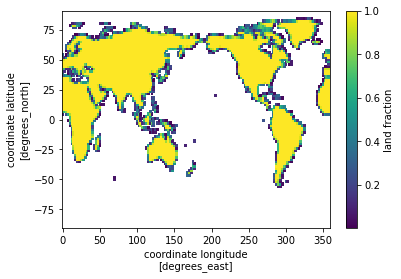

In [95]:
sg.landfrac.plot()

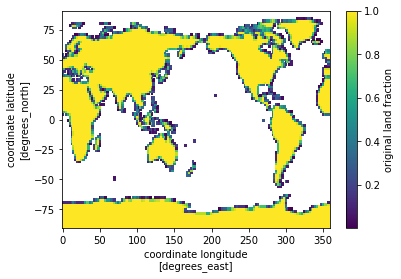

In [96]:
sg.landfrac_orig.plot()

In [89]:
x2=1/la0.sum()*(la0*ds.TLAI).sum(dim=['lat','lon']).compute()

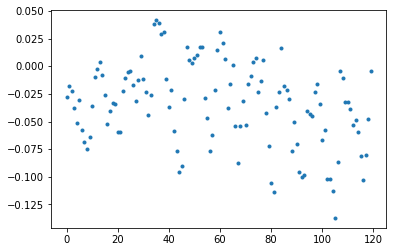

In [93]:
plt.plot(x1-x2,'.')

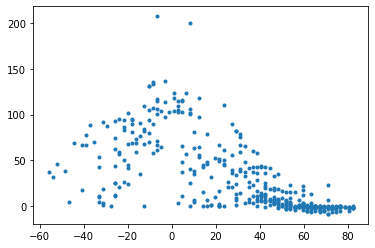

In [73]:
plt.plot(lai.lat,et.isel(time=2),'.')

In [45]:
f='/glade/scratch/linnia/archive/LAI_SP_ctsm51d115/lnd/hist/LAI_SP_ctsm51d115.clm2.h0.2000-02-01-00000.nc'
ds1=xr.open_dataset(f)
ds1['time']=xr.cftime_range('2000',periods=12,freq='MS')

lai=ds1.TLAI[:,jvals,ivals]

In [46]:
lai

<xarray.DataArray 'TLAI' (time: 12, gridcell: 400)>
array([[2.255122e+00, 1.089581e+00, 1.284320e+00, ..., 0.000000e+00,
        3.653218e-02, 1.272141e-03],
       [2.403025e+00, 1.197857e+00, 1.250578e+00, ..., 0.000000e+00,
        3.750589e-02, 1.405791e-03],
       [2.031390e+00, 1.000929e+00, 1.091520e+00, ..., 6.853802e-06,
        4.055439e-02, 1.750431e-03],
       ...,
       [9.994695e-01, 5.044150e-01, 8.105261e-01, ..., 1.235622e-02,
        7.489397e-02, 1.580280e-03],
       [1.163017e+00, 6.085276e-01, 9.262668e-01, ..., 3.121887e-03,
        5.892363e-02, 1.382359e-03],
       [1.373217e+00, 7.384959e-01, 1.051351e+00, ..., 2.469309e-04,
        3.790202e-02, 1.301674e-03]], dtype=float32)
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2000-12-01 00:00:00
    lon      (gridcell) float32 292.5 287.5 302.5 287.5 ... 307.5 325.0 340.0
    lat      (gridcell) float32 -55.89 -54.0 -52.11 -48.32 ... 82.42 82.42 82.42
Dimensions without coordinates: gridcell
Attributes:
    long_name:      total projected leaf area index
    units:          m^2/m^2
    cell_methods:   time: mean
    landunit_mask:  unknown

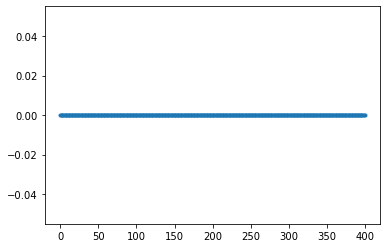

In [43]:
plt.plot(lai.lon-ds2.grid1d_lon,'.')

<xarray.DataArray 'TLAI' (time: 12, gridcell: 400)>
array([[2.255122e+00, 1.089581e+00, 1.284320e+00, ..., 0.000000e+00,
        3.653218e-02, 1.272141e-03],
       [2.403025e+00, 1.197857e+00, 1.250578e+00, ..., 0.000000e+00,
        3.750589e-02, 1.405791e-03],
       [2.031390e+00, 1.000929e+00, 1.091520e+00, ..., 6.853802e-06,
        4.055439e-02, 1.750431e-03],
       ...,
       [9.994695e-01, 5.044150e-01, 8.105261e-01, ..., 1.235622e-02,
        7.489397e-02, 1.580280e-03],
       [1.163017e+00, 6.085276e-01, 9.262668e-01, ..., 3.121887e-03,
        5.892363e-02, 1.382359e-03],
       [1.373217e+00, 7.384959e-01, 1.051351e+00, ..., 2.469309e-04,
        3.790202e-02, 1.301674e-03]], dtype=float32)
Coordinates:
  * time     (time) object 2000-02-01 00:00:00 ... 2001-01-01 00:00:00
    lon      (gridcell) float32 292.5 287.5 302.5 287.5 ... 307.5 325.0 340.0
    lat      (gridcell) float32 -55.89 -54.0 -52.11 -48.32 ... 82.42 82.42 82.42
Dimensions without coordinates: gridcell
Attributes:
    long_name:      total projected leaf area index
    units:          m^2/m^2
    cell_methods:   time: mean
    landunit_mask:  unknown

In [29]:
ds1.TLAI.sel(lat=a,lon=o) for 

<xarray.DataArray 'TLAI' (time: 12, lat: 96, lon: 144)>
[165888 values with dtype=float32]
Coordinates:
  * time     (time) object 2000-02-01 00:00:00 ... 2001-01-01 00:00:00
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
Attributes:
    long_name:      total projected leaf area index
    units:          m^2/m^2
    cell_methods:   time: mean
    landunit_mask:  unknown

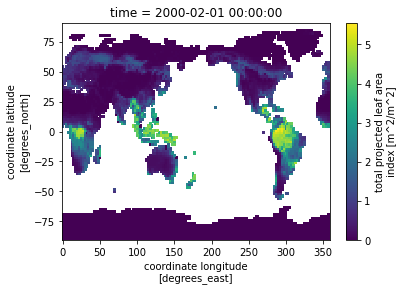

In [24]:
ds.TLAI.isel(time=0).plot()

In [26]:
o,a=sg.rcent_coords.isel(numclust=50).values
print(a,o)
ds.TLAI.sel(lat=a,lon=o,method='nearest')

46.42105 130.0


<xarray.DataArray 'TLAI' (time: 12)>
array([0.334169, 0.332981, 0.344765, 0.455172, 1.133084, 2.282569, 3.3039  ,
       3.12846 , 1.364354, 0.487191, 0.350937, 0.336426], dtype=float32)
Coordinates:
  * time     (time) object 2000-02-01 00:00:00 ... 2001-01-01 00:00:00
    lon      float32 130.0
    lat      float32 46.42
Attributes:
    long_name:      total projected leaf area index
    units:          m^2/m^2
    cell_methods:   time: mean
    landunit_mask:  unknown

### read in an example sparse output file

In [23]:
f = '/glade/scratch/djk2120/PPEn11/hist/CTL2010/PPEn08_CTL2010_OAAT0000.clm2.h0.2005-02-01-00000.nc'
ds2 = xr.open_dataset(f)
lats = ds2.grid1d_lat.values
lons = ds2.grid1d_lon.values

### plot up centroids from the output and from the sparsegrid

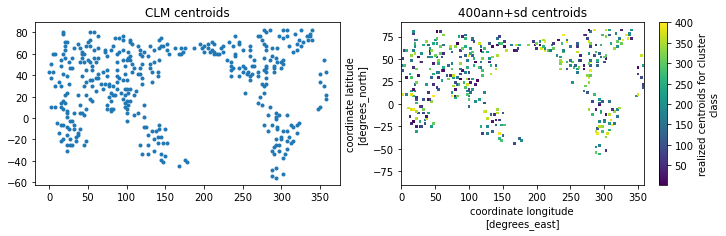

In [24]:
plt.figure(figsize=[12,3])
plt.subplot(121)
plt.plot(lons,lats,'.')
plt.title('CLM centroids')
plt.subplot(122)
ds.rcent.plot()
plt.title('400ann+sd centroids');

### the main thing
 - iterate through the CLM gridcells
 - retrieve the total represented landarea from Forrest

In [25]:
landarea = (ds.area*ds.landfrac).values
area  = np.zeros(400)
for i in range(400): 
    lat = lats[i]
    lon = lons[i]
    ixlat = abs(ds.lat-lat)<0.1
    ixlon = abs(ds.lon-lon)<0.1
    clust = ds.cclass[ixlat,ixlon].values
    ixc   = ds.cclass==clust
    area[i] = landarea[ixc].sum()
la = xr.DataArray(area,dims='gridcell',name='landarea')
la.attrs={'long_name':'total area of represented gridcells',
          'units':'km2'}

### write to netcdf

In [131]:
la.to_netcdf('sparsegrid_landarea.nc')

### check the value from the default params production run

In [116]:
thedir = '/glade/scratch/djk2120/ctsm51c6_PPEn08ctsm51d023_2deg_GSWP3V1_Sparse400_2000/run/'
thefile = glob.glob(thedir+'*.h0.*')[0]
base = xr.open_dataset(thefile)
nmonths = len(base.time)
yr0 = base['time.year'][0].values
base['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

In [145]:
gpp_mth_grid = 1e-9*24*60*60*month_wts(10)*la*base.GPP  #PgC/representd-gcell/mth
gpp_ann      = gpp_mth_grid.sum(dim='gridcell').groupby('time.year').sum()

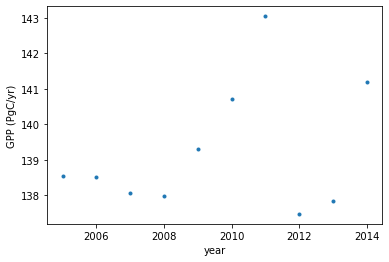

In [148]:
gpp_ann.plot.line('.')
plt.ylabel('GPP (PgC/yr)');

In [149]:
gpp_ann.mean()

<xarray.DataArray ()>
array(139.26398402)

### create a vector for pft output

In [29]:
f = '/glade/scratch/djk2120/PPEn11/hist/CTL2010/PPEn08_CTL2010_OAAT0000.clm2.h1.2005-02-01-00000.nc'
ds2 = xr.open_dataset(f)

In [30]:
lats = ds2.pfts1d_lat
lons = ds2.pfts1d_lon
wts  = ds2.pfts1d_wtgcell

In [31]:
landarea = (ds.area*ds.landfrac).values
nx = len(lats)
area_pft  = np.zeros(nx)
for i in range(nx): 
    lat = lats[i]
    lon = lons[i]
    ixlat = abs(ds.lat-lat)<0.1
    ixlon = abs(ds.lon-lon)<0.1
    clust = ds.cclass[ixlat,ixlon].values
    ixc   = ds.cclass==clust
    area_pft[i] = wts[i]*landarea[ixc].sum()

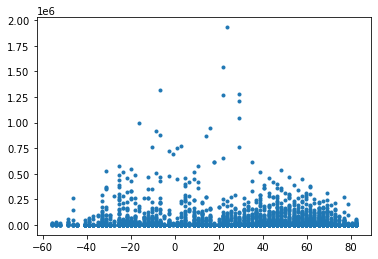

In [32]:
plt.plot(lats,area_pft,'.')

In [33]:
area_pft.sum()

135285566.9312744

In [36]:
la_pft = xr.DataArray(area_pft,dims='pft',name='landarea_pft')
la_pft.attrs={'long_name':'total area of represented patches','units':'km2'}

In [39]:
ds_out = xr.Dataset()
ds_out['landarea_pft'] = la_pft
ds_out['landarea'] = la

In [40]:
ds_out

<xarray.Dataset>
Dimensions:       (gridcell: 400, pft: 4387)
Dimensions without coordinates: gridcell, pft
Data variables:
    landarea_pft  (pft) float64 763.8 4.531e+03 7.405e+03 ... 0.0 0.0 0.0
    landarea      (gridcell) float64 4.388e+04 7.402e+04 ... 1.018e+05 4.207e+04